In [5]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nibabel as nib
from nilearn import image as nimg
from nilearn import plotting as nplot
import bids
from nltools.file_reader import onsets_to_dm
from nltools.stats import regress, zscore
from nltools.data import Brain_Data, Design_Matrix
from nltools.stats import find_spikes 
from nilearn.plotting import view_img, glass_brain, plot_stat_map
from bids import BIDSLayout, BIDSValidator
import os
from pathlib import Path
from nilearn.glm.first_level import make_first_level_design_matrix
from nilearn.plotting import plot_design_matrix
from nilearn.glm.first_level import FirstLevelModel
from nilearn import plotting
from nilearn.plotting import plot_contrast_matrix
from nilearn.glm.first_level import FirstLevelModel
from nilearn import plotting
# creating mean img for plotting purposes 
from nilearn.image import mean_img
from nilearn.image import load_img
from nibabel import load
from nibabel.gifti import GiftiDataArray, GiftiImage
from nilearn.glm.first_level import run_glm as run_glm
from nilearn.glm import compute_contrast
import nilearn

### Practice 

several different ways to go about this: 
1. ROI spheres: take the center coordinates, pick a radius around it and then just use the average time series data (1 value) for the whole sphere in first/second level
2. Neurosynth derived DMN mask: methods/mask taken from this paper here: https://www.nature.com/articles/s41598-020-72317-8#Abs1
    Using niftimasker to extract average time-series within ROIs 
4. Resting state derived DMN mask: use pcc as a seed region for resting state, localize co-activated regions and then use as binarized mask:
   https://nilearn.github.io/dev/auto_examples/04_glm_first_level/plot_adhd_dmn.html


In [3]:
# ROI spheres (method 1/2) 
dmn_coords = [(0, -52, 18), (-46, -68, 32), (46, -68, 32), (1, 50, -5)]
labels = [
    "Posterior Cingulate Cortex",
    "Left Temporoparietal junction",
    "Right Temporoparietal junction",
    "Medial prefrontal cortex",
]

#msdl atlas: 
dmn_coords_msdl = [(-45.8, -64.78, 31.84),(-0.2, -55.21, 29.87),(-0.15, 51.42, 7.58),(51.66, -59.34, 28.88)]
labels_msdl = [
        'L DMN',
        'Med DMN',
        'Front DMN',
        'R DMN',
]
# manually entered coordinates -- could probably do some sort of extraction using resting state data! 

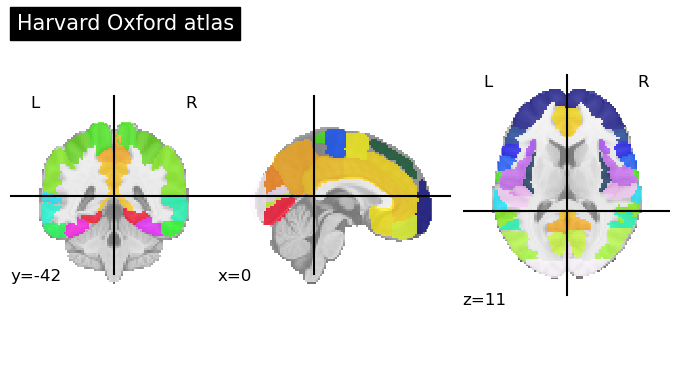

In [5]:
import numpy as np
from nilearn import datasets
from nilearn.datasets import fetch_atlas_harvard_oxford
dataset_ho = datasets.fetch_atlas_harvard_oxford("cort-maxprob-thr25-2mm")
atlas_ho_filename = dataset_ho.filename
plotting.plot_roi(atlas_ho_filename, title="Harvard Oxford atlas")

In [6]:
# Making results folder -- change to what this should actually be 
path = '/Volumes/Seagate Desktop Drive/kdata/'
os.chdir(path)
output_dir = Path.cwd() / "results" / "surface" / "first_level_results"
output_dir.mkdir(exist_ok=True, parents=True)
print(f"Output will be saved to: {output_dir}")

#isolating directory called layout_raw (for events.tsv files) -- will change depending on where data is stored / what computer we're running on
layout_raw = bids.BIDSLayout('/Volumes/Seagate Desktop Drive/kdata/', validate=True)

#isolating directory called layout (for fMRIprep derivatives) -- will change depending on where data is stored / what computer we're running on 
layout = bids.BIDSLayout('/Volumes/Seagate Desktop Drive/kdata/derivatives', validate=False,
                  config=['bids','derivatives'])
print(layout)

Output will be saved to: /Volumes/Seagate Desktop Drive/kdata/results/surface/first_level_results
BIDS Layout: ...esktop Drive/kdata/derivatives | Subjects: 58 | Sessions: 110 | Runs: 174


In [8]:
#tutorial for this: https://neurostars.org/t/create-a-10mm-sphere-roi-mask-around-a-given-coordinate/28853/3

# creating template images for plotting / first-level masks 
from nilearn import plotting, masking
from nilearn.masking import _unmask_3d
from nilearn.maskers import nifti_spheres_masker
import nibabel as nib
from nibabel import Nifti1Image
from nilearn.image import resample_to_img 

sess = '01'
sub = '102'
fmri_imgs = layout.get(subject=sub,
            datatype='func', task='selfother',session = sess,
            desc='preproc',
            space='MNI152NLin2009cAsym',
            extension='nii.gz',
           return_type='file')

space_defining_image = masking.compute_brain_mask(fmri_imgs[0])

# _, A = nifti_spheres_masker._apply_mask_and_get_affinity(
#     seeds=dmn_coords,
#     niimg=None,
#     radius=10,
#     allow_overlap=False, 
#     mask_img=space_defining_image)

# A = A.sum(axis=0)
# A = np.array(A).flatten()

# sphere_mask = _unmask_3d(A,mask=space_defining_image.get_fdata().astype(bool))
# sphere_mask = Nifti1Image(sphere_mask, space_defining_image.affine)


# can use masker to create 1 value per sphere 
from nilearn.maskers import NiftiSpheresMasker

# masker = NiftiSpheresMasker(
#     dmn_coords,
#     radius=8,
#     t_r=2.5,
#     mask_img=space_defining_image
# )

In [9]:
# method 3: neurosynth DMN mask: 
from nilearn.image import resample_to_img 
# We extract data from ROIs using nilearn's NiftiLabelsMasker
from nilearn.maskers import NiftiLabelsMasker

#import DMN Neurosynth mask:
dmn_mask_raw = load_img('/Volumes/Seagate Desktop Drive/kdata/DMN masks/DMN.nii.gz')
dmn_labels = resample_to_img(source_img=dmn_mask_raw, target_img=space_defining_image, interpolation='nearest')

# First, initialize masker 
masker = NiftiLabelsMasker(
    dmn_labels, mask_img=space_defining_image
)

#average signal across DMN regions (PCC, mPFC, lTPJ, rTPJ)
# dmn_data = dmn_mask4.get_fdata()
# binarized_data = (dmn_data > 0).astype(bool)
# dmn_avg_mask = Nifti1Image(binarized_data, dmn_mask4.affine, header=dmn_mask4.header)


In [10]:
# needed for making design matrix 
# note: keep MNI files for isolating tr / frames bc easier to load 
def load_bids_events(layout,layout_raw, subject, run, session):
    '''Create a design_matrix instance from BIDS event file'''
    
    tr = 2.5 #put in manually bc get_tr wouldn't work?? 
    # change lines below -- can change to "mask", change task to "self-other"
    func_files = layout.get(subject=subject,
                        datatype='func', task='selfother',session = session,
                        desc='preproc',
                        space='MNI152NLin2009cAsym',
                        extension='nii.gz',
                       return_type='file')
    func_file = nimg.load_img(func_files[run])
    n_tr = func_file.shape[-1]

    onsets = pd.read_csv(layout_raw.get(subject=subject, suffix='events', session = session)[run].path)
    # line below is isolating the onset, duration, and trial type columns -- change according to events.tsv format 
    onsets_actual = onsets.iloc[:, [0,1,3]]
    onsets_actual.columns = ['onset', 'duration','trial_type'] # make sure this order matches with what's loaded in as "onsets_actua
    sampling_freq = 1/tr
    n_scans=n_tr
    return onsets_actual, tr, n_scans

In [11]:
# subjects missing ses02:
# 102, 138, 145, 209, 221, 237 
subjects = layout.get_subjects()
subjects2 = []
subjects2 = subjects
#subjects2 = subjects
#testing second level (removing all subs with errors) 
del(subjects2[0]) #- 102 
del(subjects2[21]) #- 138 +1
del(subjects2[25]) #- 145 +1 
del(subjects2[32]) #- 209 +1 
del(subjects2[40]) #- 221 +1 
del(subjects2[50]) #- 237 +2 

subjects = layout.get_subjects()

Creating First Level Design matrix ... 
First Level Design Matrix completed
Fitting first-level GLM ...
self-other: Z-score outputs: [ 1.45309418  1.17329039  1.43437047 -0.37263669]


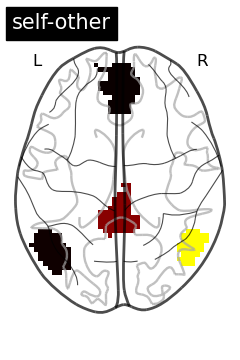

self-fix: Z-score outputs: [-0.26138535 -1.14125957 -1.16323633 -1.20563335]


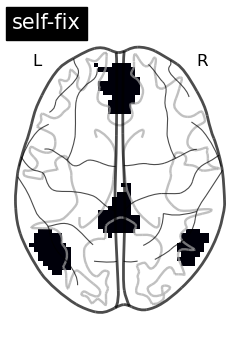

other-fix: Z-score outputs: [-2.0224516  -2.54173878 -2.88516008 -0.74411921]


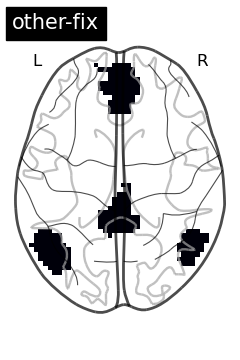

case-fix: Z-score outputs: [-0.22825313 -1.44005593 -2.38649861  0.87303672]


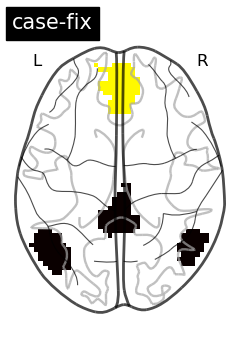

In [13]:
# Method 1: just running first level on ROI spheres, then interpolating back to the nifti image -- 1 average value for the ROI 

sess = '01'
sub = '102'
fmri_imgs = layout.get(subject=sub,
            datatype='func', task='selfother',session = sess,
            desc='preproc',
            space='MNI152NLin2009cAsym',
            extension='nii.gz',
           return_type='file')
hrf_model = "spm" #canonical hrf 
high_pass = 0.01 # The cutoff for the drift model is 0.01 Hz.

dmn_time_series = []
for con_img in fmri_imgs:
    dmn_time_series.append(masker.fit_transform(con_img))
dmn_time_series = np.concatenate(dmn_time_series, axis = 0)

confound_files = layout.get(subject=sub,
                datatype='func', task='selfother',session = sess,
                desc='confounds',
               extension="tsv",
               return_type='file')

# Select confounds -- set right now to just the 6 motion parameters but can add in more/less! 
#36 confound_vars 
confound_vars = ['trans_x','trans_x_derivative1','trans_x_derivative1_power2','trans_x_power2',
                   'trans_y','trans_y_derivative1','trans_y_derivative1_power2','trans_y_power2',
                     'trans_z','trans_z_derivative1','trans_z_derivative1_power2','trans_z_power2',
                     'rot_x','rot_x_derivative1','rot_x_derivative1_power2','rot_x_power2',
                     'rot_y','rot_y_derivative1','rot_y_derivative1_power2','rot_y_power2',
                     'rot_z','rot_z_derivative1','rot_z_derivative1_power2','rot_z_power2',
                     'csf','csf_derivative1','csf_derivative1_power2','csf_power2',
                     'white_matter','white_matter_derivative1','white_matter_derivative1_power2','white_matter_power2'
                    ]

final_confounds = confound_vars

design_matrices = []

print("Creating First Level Design matrix ... ")

for idx, img in enumerate(fmri_imgs):
# Build experimental paradigm
    run = idx
    events,tr,n_scans = load_bids_events(layout,layout_raw, sub, run, sess)
# Define the sampling times for the design matrix
    frame_times = np.arange(n_scans) * tr
    confound_file = confound_files[run]
    confound_df = pd.read_csv(confound_file, delimiter='\t')
    confound_df = confound_df[final_confounds]
    confound_df.fillna(0, inplace=True)
# Build design matrix with the previously defined parameters
    design_matrix = make_first_level_design_matrix(
        frame_times,
        events,
        hrf_model=hrf_model,
        drift_model="polynomial",
        drift_order=3,
        add_regs=confound_df,
        add_reg_names=confound_vars,
        high_pass=high_pass,
    )
    design_matrix = design_matrix.iloc[:,0:11] # taking out constant intercept and adding in an intercept for each individual run
# this allows average voxel to vary across runs instead of assuming its constant 
    if idx == 0:
        design_matrix['intercept1'] = 1 
        design_matrix['intercept2'] = 0
        design_matrix['intercept3'] = 0
    elif idx == 1:
        design_matrix['intercept1'] = 0
        design_matrix['intercept2'] = 1 
        design_matrix['intercept3'] = 0
    else: 
        design_matrix['intercept1'] = 0
        design_matrix['intercept2'] = 0 
        design_matrix['intercept3'] = 1
# put the design matrices in a list / concatenate 
    design_matrices.append(design_matrix)
design_matrix_allruns = []    
design_matrix_allruns = np.concatenate(design_matrices, axis = 0)

print("First Level Design Matrix completed")

contrast_matrix = np.eye(design_matrix.shape[1])
basic_contrasts = {
    column: contrast_matrix[i]
    for i, column in enumerate(design_matrix.columns)
}

contrasts = {
    "self-other": (basic_contrasts["self"] - basic_contrasts["other"]),
    "self-fix": (basic_contrasts["self"] - basic_contrasts["fix"]),
    "other-fix": (basic_contrasts["other"] - basic_contrasts["fix"]),
    "case-fix": (basic_contrasts["case"] - basic_contrasts["fix"]),

}

print("Fitting first-level GLM ...")

#fmri_glm = FirstLevelModel()
labels, estimates = run_glm(dmn_time_series, design_matrix_allruns)

for index, (contrast_id, contrast_val) in enumerate(contrasts.items()):

# compute contrast-related statistics
    contrast = compute_contrast(labels, estimates, contrast_val)

    z_score = contrast.z_score()
    print(f"{contrast_id}: Z-score outputs: {z_score}") 
    plotimg = masker.inverse_transform(z_score)

    plotting.plot_glass_brain(
            plotimg,
            display_mode="z",
            title=contrast_id,
            )
    plotting.show()
    

Creating First Level Design matrix ... 
First Level Design Matrix completed
Fitting first-level GLM ...


/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:799: UserWarning: One contrast given, assuming it for all 3 runs
  warn(f"One contrast given, assuming it for all {int(n_runs)} runs")


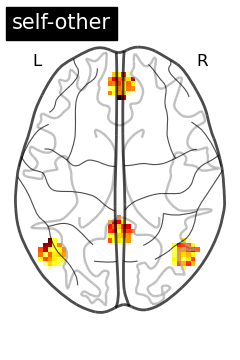

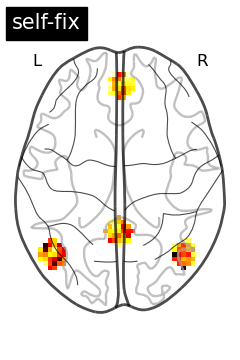

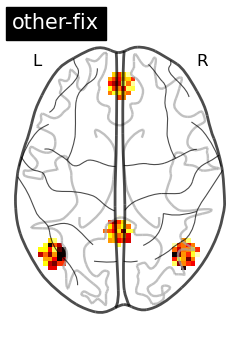

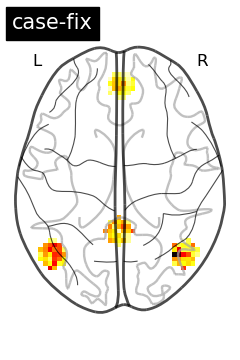

In [14]:
# Method 2: applying binary mask of ROI sphere regions to first level -- values able to vary within the ROI sphere 

sess = '01'
sub = '102'
fmri_imgs = layout.get(subject=sub,
            datatype='func', task='selfother',session = sess,
            desc='preproc',
            space='MNI152NLin2009cAsym',
            extension='nii.gz',
           return_type='file')
hrf_model = "spm" #canonical hrf 
high_pass = 0.01 # The cutoff for the drift model is 0.01 Hz.

confound_files = layout.get(subject=sub,
                datatype='func', task='selfother',session = sess,
                desc='confounds',
               extension="tsv",
               return_type='file')

# Select confounds -- set right now to just the 6 motion parameters but can add in more/less! 
#36 confound_vars 
confound_vars = ['trans_x','trans_x_derivative1','trans_x_derivative1_power2','trans_x_power2',
                   'trans_y','trans_y_derivative1','trans_y_derivative1_power2','trans_y_power2',
                     'trans_z','trans_z_derivative1','trans_z_derivative1_power2','trans_z_power2',
                     'rot_x','rot_x_derivative1','rot_x_derivative1_power2','rot_x_power2',
                     'rot_y','rot_y_derivative1','rot_y_derivative1_power2','rot_y_power2',
                     'rot_z','rot_z_derivative1','rot_z_derivative1_power2','rot_z_power2',
                     'csf','csf_derivative1','csf_derivative1_power2','csf_power2',
                     'white_matter','white_matter_derivative1','white_matter_derivative1_power2','white_matter_power2'
                    ]

final_confounds = confound_vars

design_matrices = []

print("Creating First Level Design matrix ... ")

for idx, img in enumerate(fmri_imgs):
# Build experimental paradigm
    run = idx
    events,tr,n_scans = load_bids_events(layout,layout_raw, sub, run, sess)
# Define the sampling times for the design matrix
    frame_times = np.arange(n_scans) * tr
    confound_file = confound_files[run]
    confound_df = pd.read_csv(confound_file, delimiter='\t')
    confound_df = confound_df[final_confounds]
    confound_df.fillna(0, inplace=True)
# Build design matrix with the previously defined parameters
    design_matrix = make_first_level_design_matrix(
        frame_times,
        events,
        hrf_model=hrf_model,
        drift_model="polynomial",
        drift_order=3,
        add_regs=confound_df,
        add_reg_names=confound_vars,
        high_pass=high_pass,
    )
    design_matrix = design_matrix.iloc[:,0:11] # taking out constant intercept and adding in an intercept for each individual run
# this allows average voxel to vary across runs instead of assuming its constant 
    if idx == 0:
        design_matrix['intercept1'] = 1 
        design_matrix['intercept2'] = 0
        design_matrix['intercept3'] = 0
    elif idx == 1:
        design_matrix['intercept1'] = 0
        design_matrix['intercept2'] = 1 
        design_matrix['intercept3'] = 0
    else: 
        design_matrix['intercept1'] = 0
        design_matrix['intercept2'] = 0 
        design_matrix['intercept3'] = 1
# put the design matrices in a list / concatenate 
    design_matrices.append(design_matrix)
design_matrix_allruns = []    
design_matrix_allruns = np.concatenate(design_matrices, axis = 0)

print("First Level Design Matrix completed")

contrast_matrix = np.eye(design_matrix.shape[1])
basic_contrasts = {
    column: contrast_matrix[i]
    for i, column in enumerate(design_matrix.columns)
}

contrasts = {
    "self-other": (basic_contrasts["self"] - basic_contrasts["other"]),
    "self-fix": (basic_contrasts["self"] - basic_contrasts["fix"]),
    "other-fix": (basic_contrasts["other"] - basic_contrasts["fix"]),
    "case-fix": (basic_contrasts["case"] - basic_contrasts["fix"]),

}

print("Fitting first-level GLM ...")

#fmri_glm = FirstLevelModel()
fmri_glm = FirstLevelModel(mask_img = sphere_mask)
#no gm mask 
#fmri_glm = FirstLevelModel()

fmri_glm = fmri_glm.fit(fmri_imgs, design_matrices=design_matrices)

# Iterate on contrasts
for contrast_id, contrast_val in contrasts.items():
#print(f"\tcontrast id: {contrast_id}")
# compute the contrasts
    outputs = fmri_glm.compute_contrast(contrast_val, output_type='all')
# plot the contrasts as soon as they're generated
# the display is overlaid on the mean fMRI image
# a threshold of 3.0 is used, more sophisticated choices are possible
    #print(f"{contrast_id}: Z-score outputs: {z_score}") 
    plotting.plot_glass_brain(
        outputs['z_score'],
        display_mode="z",
        title=contrast_id,
    )
    plotting.show()
 

In [15]:
# Method 3: applying binary mask of Neurosynth DMN regions to first level -- values able to vary within the ROI sphere 

sess = '01'
sub = '102'
fmri_imgs = layout.get(subject=sub,
            datatype='func', task='selfother',session = sess,
            desc='preproc',
            space='MNI152NLin2009cAsym',
            extension='nii.gz',
           return_type='file')
hrf_model = "spm" #canonical hrf 
high_pass = 0.01 # The cutoff for the drift model is 0.01 Hz.

confound_files = layout.get(subject=sub,
                datatype='func', task='selfother',session = sess,
                desc='confounds',
               extension="tsv",
               return_type='file')

# Select confounds -- set right now to just the 6 motion parameters but can add in more/less! 
#36 confound_vars 
confound_vars = ['trans_x','trans_x_derivative1','trans_x_derivative1_power2','trans_x_power2',
                   'trans_y','trans_y_derivative1','trans_y_derivative1_power2','trans_y_power2',
                     'trans_z','trans_z_derivative1','trans_z_derivative1_power2','trans_z_power2',
                     'rot_x','rot_x_derivative1','rot_x_derivative1_power2','rot_x_power2',
                     'rot_y','rot_y_derivative1','rot_y_derivative1_power2','rot_y_power2',
                     'rot_z','rot_z_derivative1','rot_z_derivative1_power2','rot_z_power2',
                     'csf','csf_derivative1','csf_derivative1_power2','csf_power2',
                     'white_matter','white_matter_derivative1','white_matter_derivative1_power2','white_matter_power2'
                    ]

final_confounds = confound_vars

design_matrices = []

print("Creating First Level Design matrix ... ")

for idx, img in enumerate(fmri_imgs):
# Build experimental paradigm
    run = idx
    events,tr,n_scans = load_bids_events(layout,layout_raw, sub, run, sess)
# Define the sampling times for the design matrix
    frame_times = np.arange(n_scans) * tr
    confound_file = confound_files[run]
    confound_df = pd.read_csv(confound_file, delimiter='\t')
    confound_df = confound_df[final_confounds]
    confound_df.fillna(0, inplace=True)
# Build design matrix with the previously defined parameters
    design_matrix = make_first_level_design_matrix(
        frame_times,
        events,
        hrf_model=hrf_model,
        drift_model="polynomial",
        drift_order=3,
        add_regs=confound_df,
        add_reg_names=confound_vars,
        high_pass=high_pass,
    )
    design_matrix = design_matrix.iloc[:,0:11] # taking out constant intercept and adding in an intercept for each individual run
# this allows average voxel to vary across runs instead of assuming its constant 
    if idx == 0:
        design_matrix['intercept1'] = 1 
        design_matrix['intercept2'] = 0
        design_matrix['intercept3'] = 0
    elif idx == 1:
        design_matrix['intercept1'] = 0
        design_matrix['intercept2'] = 1 
        design_matrix['intercept3'] = 0
    else: 
        design_matrix['intercept1'] = 0
        design_matrix['intercept2'] = 0 
        design_matrix['intercept3'] = 1
# put the design matrices in a list / concatenate 
    design_matrices.append(design_matrix)
design_matrix_allruns = []    
design_matrix_allruns = np.concatenate(design_matrices, axis = 0)

print("First Level Design Matrix completed")

contrast_matrix = np.eye(design_matrix.shape[1])
basic_contrasts = {
    column: contrast_matrix[i]
    for i, column in enumerate(design_matrix.columns)
}

contrasts = {
    "self-other": (basic_contrasts["self"] - basic_contrasts["other"]),
    "self-fix": (basic_contrasts["self"] - basic_contrasts["fix"]),
    "other-fix": (basic_contrasts["other"] - basic_contrasts["fix"]),
    "case-fix": (basic_contrasts["case"] - basic_contrasts["fix"]),

}

print("Fitting first-level GLM ...")

#fmri_glm = FirstLevelModel()
fmri_glm = FirstLevelModel(mask_img = dmn_mask)
#no gm mask 
#fmri_glm = FirstLevelModel()

fmri_glm = fmri_glm.fit(fmri_imgs, design_matrices=design_matrices)

# Iterate on contrasts
for contrast_id, contrast_val in contrasts.items():
#print(f"\tcontrast id: {contrast_id}")
# compute the contrasts
    outputs = fmri_glm.compute_contrast(contrast_val, output_type='all')
# plot the contrasts as soon as they're generated
# the display is overlaid on the mean fMRI image
# a threshold of 3.0 is used, more sophisticated choices are possible
    #print(f"{contrast_id}: Z-score outputs: {z_score}") 
    plotting.plot_glass_brain(
        outputs['z_score'],
        display_mode="z",
        title=contrast_id,
    )
    plotting.show()
 

Creating First Level Design matrix ... 
First Level Design Matrix completed
Fitting first-level GLM ...


NameError: name 'dmn_mask' is not defined

### First/Second Level with just DMN rois (mPFC, PCC, lTPJ, rTPJ)

In [12]:
# Average activity within Neurosynth derived regions 

from scipy.stats import norm

p001_unc = norm.isf(0.001)

file_lists = {"self-other": list(),
    "other-fix": list(),
     "self-fix": list(),
     "case-fix": list()
    }

sub_order = {"self-other": list(),
    "other-fix": list(),
     "self-fix": list(),
     "case-fix": list()
    }

nosessions = ['01','02']

for sess in nosessions: 

    if sess == '01':
        subject_list = subjects
    elif sess == '02':
        subject_list = subjects2
    
    for sub in subject_list: 
# change lines below -- can change to "mask", change task to "self-other" -- should match the same format as in the load_bids_events function
        fmri_imgs = layout.get(subject=sub,
                    datatype='func', task='selfother',session = sess,
                    desc='preproc',
                    space='MNI152NLin2009cAsym',
                    extension='nii.gz',
                   return_type='file')
        hrf_model = "spm" #canonical hrf 
        high_pass = 0.01 # The cutoff for the drift model is 0.01 Hz.

        dmn_time_series = []
        for con_img in fmri_imgs:
            dmn_time_series.append(masker.fit_transform(con_img))
        dmn_time_series = np.concatenate(dmn_time_series, axis = 0)

        confound_files = layout.get(subject=sub,
                        datatype='func', task='selfother',session = sess,
                        desc='confounds',
                       extension="tsv",
                       return_type='file')

# Select confounds -- set right now to just the 6 motion parameters but can add in more/less! 
       #32 confound_vars -- TOOK OUT GLOBAL SIGNAL 
        confound_vars = ['trans_x','trans_x_derivative1','trans_x_derivative1_power2','trans_x_power2',
                           'trans_y','trans_y_derivative1','trans_y_derivative1_power2','trans_y_power2',
                             'trans_z','trans_z_derivative1','trans_z_derivative1_power2','trans_z_power2',
                             'rot_x','rot_x_derivative1','rot_x_derivative1_power2','rot_x_power2',
                             'rot_y','rot_y_derivative1','rot_y_derivative1_power2','rot_y_power2',
                             'rot_z','rot_z_derivative1','rot_z_derivative1_power2','rot_z_power2',
                             'csf','csf_derivative1','csf_derivative1_power2','csf_power2',
                             'white_matter','white_matter_derivative1','white_matter_derivative1_power2','white_matter_power2'
                            ]
        #6 confound vars
        #confound_vars = ['trans_x','trans_y','trans_z',
         #        'rot_x','rot_y','rot_z']
        final_confounds = confound_vars

        design_matrices = []

        for idx, img in enumerate(fmri_imgs):
# Build experimental paradigm
            run = idx
            events,tr,n_scans = load_bids_events(layout,layout_raw, sub, run, sess)
    # Define the sampling times for the design matrix
            frame_times = np.arange(n_scans) * tr
            confound_file = confound_files[run]
            confound_df = pd.read_csv(confound_file, delimiter='\t')
            confound_df = confound_df[final_confounds]
            confound_df.fillna(0, inplace=True)
    # Build design matrix with the previously defined parameters
            design_matrix = make_first_level_design_matrix(
                frame_times,
                events,
                hrf_model=hrf_model,
                drift_model="polynomial",
                drift_order=3,
                add_regs=confound_df,
                add_reg_names=confound_vars,
                high_pass=high_pass,
            )
            design_matrix = design_matrix.iloc[:,0:11] # taking out constant intercept and adding in an intercept for each individual run
# this allows average voxel to vary across runs instead of assuming its constant 
            if idx == 0:
                design_matrix['intercept1'] = 1 
                design_matrix['intercept2'] = 0
                design_matrix['intercept3'] = 0
            elif idx == 1:
                design_matrix['intercept1'] = 0
                design_matrix['intercept2'] = 1 
                design_matrix['intercept3'] = 0
            else: 
                design_matrix['intercept1'] = 0
                design_matrix['intercept2'] = 0 
                design_matrix['intercept3'] = 1
    # put the design matrices in a list
            design_matrices.append(design_matrix)
            design_matrix_allruns = []    
            design_matrix_allruns = np.concatenate(design_matrices, axis = 0)    
# can visualize the design matrix with the line below 
#plot_design_matrix(design_matrices[1])
        contrast_matrix = np.eye(design_matrix.shape[1])
        basic_contrasts = {
            column: contrast_matrix[i]
            for i, column in enumerate(design_matrix.columns)
        }

        contrasts = {
            "self-other": (basic_contrasts["self"] - basic_contrasts["other"]),
            "self-fix": (basic_contrasts["self"] - basic_contrasts["fix"]),
            "other-fix": (basic_contrasts["other"] - basic_contrasts["fix"]),
            "case-fix": (basic_contrasts["case"] - basic_contrasts["fix"]),

        }
        #added gm mask 
        #fmri_glm = FirstLevelModel()
        labels, estimates = run_glm(dmn_time_series, design_matrix_allruns)
        
        for index, (contrast_id, contrast_val) in enumerate(contrasts.items()):
        
        # compute contrast-related statistics
            contrast = compute_contrast(labels, estimates, contrast_val)

            file_lists[contrast_id].append(contrast)
            sub_order[contrast_id].append('sub'+ sub + '-ses' + sess)            
            z_score = contrast.z_score()
            print(f"{contrast_id}: Z-score outputs: {z_score}") 
        print("Subject = " + sub + " Completed!")
          

self-other: Z-score outputs: [ 1.45309418  1.17329039  1.43437047 -0.37263669]
self-fix: Z-score outputs: [-0.26138535 -1.14125957 -1.16323633 -1.20563335]
other-fix: Z-score outputs: [-2.0224516  -2.54173878 -2.88516008 -0.74411921]
case-fix: Z-score outputs: [-0.22825313 -1.44005593 -2.38649861  0.87303672]
Subject = 102 Completed!
self-other: Z-score outputs: [ 1.21562102  0.01375723 -0.04722031 -0.2455354 ]
self-fix: Z-score outputs: [-0.60680065  0.19836391  2.70622171  1.11443301]
other-fix: Z-score outputs: [-2.08360069  0.1819594   2.76637216  1.41283682]
case-fix: Z-score outputs: [ 0.14837069 -0.52224377  1.25845639  1.55696504]
Subject = 103 Completed!
self-other: Z-score outputs: [ 1.16856974  0.15407009 -0.49829326 -2.05785221]
self-fix: Z-score outputs: [-1.38960033 -0.00648184 -2.18410897 -3.19967254]
other-fix: Z-score outputs: [-2.81206372 -0.19399488 -1.58878545 -0.71623797]
case-fix: Z-score outputs: [-3.87137298 -2.1133677  -3.08232978 -0.93004205]
Subject = 107 Com

In [237]:
labels, estimates = run_glm(dmn_time_series, design_matrix_allruns)
labels

array(['0.3', '0.64', '0.76', '0.79'], dtype='<U4')

Second level 

In [204]:
second_level_input = []
for i in file_lists['self-other']:
    second_level_input.append(i.effect_size())

second_level_input = np.concatenate(second_level_input,axis=0)  

mPFC / ses01 / Patients : 2.2798247412319683 +/- 0.3234352470980968
mPFC / ses01 / Controls : 1.5710628730097034 +/- 0.31500913516167434
mPFC / ses02 / Patients : 2.061292787453331 +/- 0.5389978643442208
mPFC / ses02 / Controls : 1.1157556528258419 +/- 0.347076990816139
PCC / ses01 / Patients : 0.08981518979860424 +/- 0.17984039889833417
PCC / ses01 / Controls : 0.0028902842910195703 +/- 0.24136811650343276
PCC / ses02 / Patients : 0.6929956412776425 +/- 0.2824202894604412
PCC / ses02 / Controls : -0.2428114858375675 +/- 0.22608347875707951
lTPJ / ses01 / Patients : -0.12447929918038708 +/- 0.2715556313951213
lTPJ / ses01 / Controls : -0.13758622836804063 +/- 0.34214975672211234
lTPJ / ses02 / Patients : 0.7489524488417936 +/- 0.49881823286645655
lTPJ / ses02 / Controls : 0.02348904424045518 +/- 0.31369792412352593
rTPJ / ses01 / Patients : -1.1488519207101995 +/- 0.28137392670355366
rTPJ / ses01 / Controls : -0.6899429265935997 +/- 0.3474060450981641
rTPJ / ses02 / Patients : -0.30752

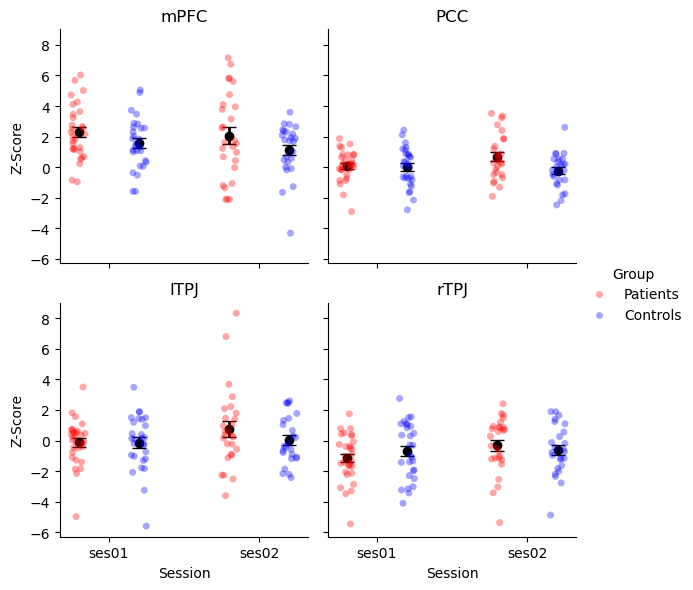

In [205]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import sem

def check_subject_id(subject_id, group):
    if group == 1:
        return subject_id.startswith('sub1')
    elif group == 2:
        return subject_id.startswith('sub2')
    else:
        return False

# Find indices for subjects in group 1 (100s) and group 2 (200s) for ses01 and ses02
patients_ses01_indices = [i for i, sub in enumerate(sub_order['self-other']) if check_subject_id(sub, 1) and sub.endswith('-ses01')]
controls_ses01_indices = [i for i, sub in enumerate(sub_order['self-other']) if check_subject_id(sub, 2) and sub.endswith('-ses01')]
patients_ses02_indices = [i for i, sub in enumerate(sub_order['self-other']) if check_subject_id(sub, 1) and sub.endswith('-ses02')]
controls_ses02_indices = [i for i, sub in enumerate(sub_order['self-other']) if check_subject_id(sub, 2) and sub.endswith('-ses02')]

# Extract z-scores for ses01 and ses02
z_scores_patients_ses01 = second_level_input[patients_ses01_indices, :]
z_scores_patients_ses02 = second_level_input[patients_ses02_indices, :]
z_scores_controls_ses01 = second_level_input[controls_ses01_indices, :]
z_scores_controls_ses02 = second_level_input[controls_ses02_indices, :]

# Creating separate scatter plots for each region
regions = ['mPFC', 'PCC', 'lTPJ', 'rTPJ']

# Prepare a DataFrame for Seaborn
data = {
    'Z-Score': [],
    'Session': [],
    'Group': [],
    'Region': [],
    'SubjectID': []
}

for region_index, region in enumerate(regions):
    for i, sub in zip(range(len(z_scores_patients_ses01)), patients_ses01_indices):
        data['Z-Score'].append(z_scores_patients_ses01[i, region_index])
        data['Session'].append('ses01')
        data['Group'].append('Patients')
        data['Region'].append(region)
        data['SubjectID'].append(sub_order['self-other'][sub])

    for i, sub in zip(range(len(z_scores_controls_ses01)), controls_ses01_indices):
        data['Z-Score'].append(z_scores_controls_ses01[i, region_index])
        data['Session'].append('ses01')
        data['Group'].append('Controls')
        data['Region'].append(region)
        data['SubjectID'].append(sub_order['self-other'][sub])

    for i, sub in zip(range(len(z_scores_patients_ses02)), patients_ses02_indices):
        data['Z-Score'].append(z_scores_patients_ses02[i, region_index])
        data['Session'].append('ses02')
        data['Group'].append('Patients')
        data['Region'].append(region)
        data['SubjectID'].append(sub_order['self-other'][sub])

    for i, sub in zip(range(len(z_scores_controls_ses02)), controls_ses02_indices):
        data['Z-Score'].append(z_scores_controls_ses02[i, region_index])
        data['Session'].append('ses02')
        data['Group'].append('Controls')
        data['Region'].append(region)
        data['SubjectID'].append(sub_order['self-other'][sub])

df = pd.DataFrame(data)

# Plotting with Seaborn's catplot
g = sns.catplot(
    data=df,
    x='Session',
    y='Z-Score',
    hue='Group',
    col='Region',
    kind='strip',
    palette={'Patients': 'red', 'Controls': 'blue'},
    col_wrap=2,
    height=3,
    aspect=1,
    jitter=True,
    dodge=True,
    alpha=0.35  # Make the subject-wise dots more transparent
)


# Add mean points for each group and session with jitter and error bars
mean_points = df.groupby(['Session', 'Group', 'Region'])['Z-Score'].mean().reset_index()
sem_points = df.groupby(['Session', 'Group', 'Region'])['Z-Score'].apply(sem).reset_index()

jitter_amount = [0, 0.4]  # Adjust the jitter amount as needed

for ax, region in zip(g.axes.flat, regions):
    for session, session_offset in zip(['ses01', 'ses02'], [0, 1]):
        for group, color, no in zip(['Patients', 'Controls'], ['red', 'blue'], [0,1]):
            subset_mean = mean_points[(mean_points['Region'] == region) & (mean_points['Session'] == session) & (mean_points['Group'] == group)]
            subset_sem = sem_points[(sem_points['Region'] == region) & (sem_points['Session'] == session) & (sem_points['Group'] == group)]
            if not subset_mean.empty:
                mean_val = subset_mean['Z-Score'].values[0]
                sem_val = subset_sem['Z-Score'].values[0]
                print(f"{region} / {session} / {group} : {mean_val} +/- {sem_val}")
                jittered_session = session_offset-0.2 + jitter_amount[no]
                ax.errorbar(jittered_session, mean_val, yerr=sem_val, fmt='o', color='black', ecolor='black', elinewidth=2, capsize=5, label=f'{group} Mean' if session == 'ses01' else "")

# Add legend
handles, labels = ax.get_legend_handles_labels()
# g.fig.legend(handles, labels, loc='upper center', ncol=2)

# Set titles for the subplots
for ax, region in zip(g.axes.flat, regions):
    ax.set_title(f'{region}')

# Save the figure as a high-quality image
g.savefig('dmn_prevpost_werrorbars_selfvother.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


In [183]:
# making second-level design matrix 

# patient group variable 
group1 = []
group2 = []
patients = []
for sub in subjects:
    if int(sub) < 200:
        group_as = 1
    else:
        group_as = 0
    group1.append(group_as)
for sub in subjects2: 
    if int(sub) < 200:
        group_as = 1
    else:
        group_as = 0
    group2.append(group_as)
patients = np.concatenate((np.array(group1),np.array(group2)))
patients = np.expand_dims(patients, axis = -1)

group1 = []
group2 = []
controls = []
for sub in subjects: 
    if int(sub) < 200:
        group_as = 0
    else:
        group_as = 1
    group1.append(group_as)
for sub in subjects2: 
    if int(sub) < 200:
        group_as = 0
    else:
        group_as = 1
    group2.append(group_as)
controls = np.concatenate((np.array(group1),np.array(group2)))
controls = np.expand_dims(controls, axis = -1)

# session variable
post = []
session1 = np.zeros(len(subjects))
session2 = np.ones(len(subjects2))
post = np.concatenate((session1,session2))
post = np.expand_dims(post, axis = -1)

# session variable
pre = []
session1 = np.ones(len(subjects))
session2 = np.zeros(len(subjects2))
pre = np.concatenate((session1,session2))
pre = np.expand_dims(pre, axis = -1)

#subject-wise intercept
sub_matrix = np.identity(len(subjects))
sub_matrix2 = np.delete(sub_matrix, 0, axis=0)  #- 102
sub_matrix2 = np.delete(sub_matrix2, 21, axis=0)  #- 138
sub_matrix2 = np.delete(sub_matrix2, 25, axis=0)  #- 145
sub_matrix2 = np.delete(sub_matrix2, 32, axis=0)  #- 209
sub_matrix2 = np.delete(sub_matrix2, 40, axis=0)  #- 221
sub_matrix2 = np.delete(sub_matrix2, 50, axis=0)  #- 237
sub_matrix = np.concatenate((sub_matrix,sub_matrix2))

# put all together 
second_level_design_matrix = np.hstack((patients,controls,pre,post,sub_matrix))

# delete out subs who didn't have second session ()

In [184]:
# fitting second level glm! 
secondlevel_labels, secondlevel_estimates = run_glm(second_level_input, second_level_design_matrix)

In [185]:
second_level_design_matrix
second_level_design_matrix = pd.DataFrame(second_level_design_matrix, columns=['patients'] + ['controls'] +['pre'] +['post'] + subjects)
#second_level_design_matrix.to_excel("/Users/angelafang/Desktop/test.xlsx")
second_level_design_matrix.shape

(110, 62)

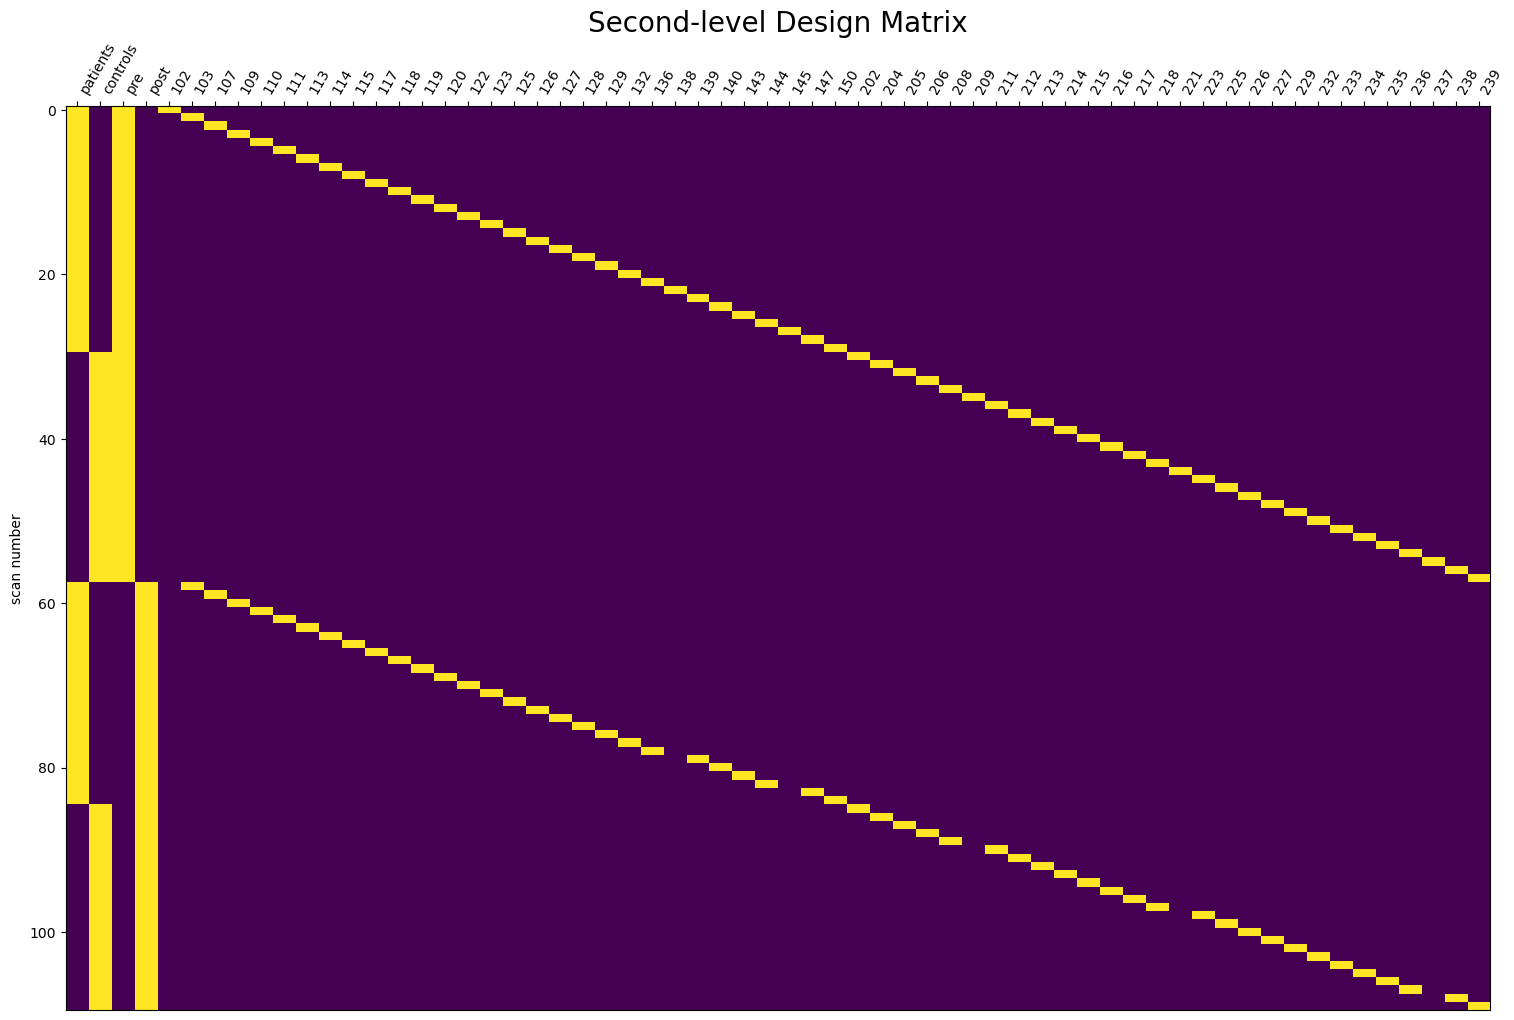

In [186]:
from nilearn.glm.second_level import SecondLevelModel 
plotting.plot_design_matrix(second_level_design_matrix, rescale=False)
plt.title("Second-level Design Matrix", fontsize=20)
plotting.show()

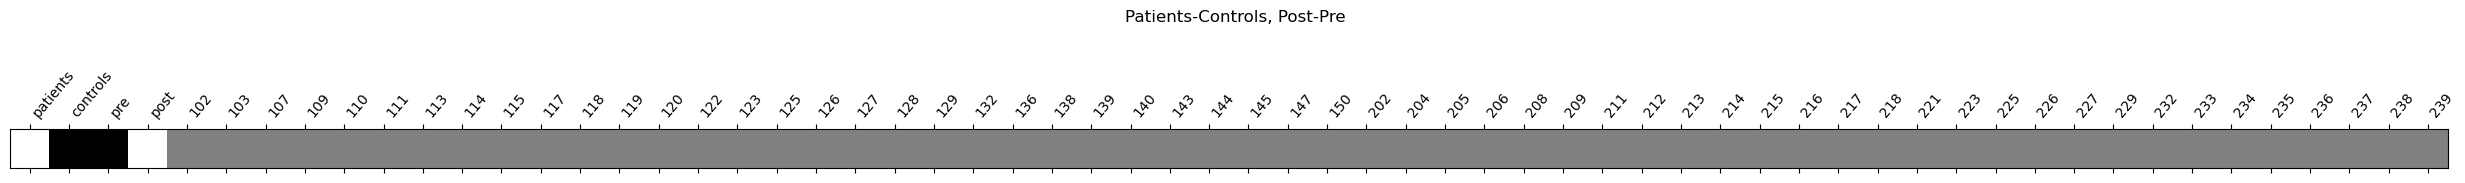

In [187]:
#Making contrasts! 
contrast_matrix = np.eye(second_level_design_matrix.shape[1])
basic_contrasts = {
    column: contrast_matrix[i]
    for i, column in enumerate(second_level_design_matrix.columns)
    }

contrasts = {
    "Patients-Controls, Post-Pre": (basic_contrasts["patients"]-basic_contrasts["controls"]+basic_contrasts["post"]-basic_contrasts["pre"]),
    # "Post-Pre": (basic_contrasts["post"]-basic_contrasts["pre"]),
    # "Patients-Controls": (basic_contrasts["patients"]-basic_contrasts["controls"]),
    }      
contrasts

from nilearn.plotting import plot_contrast_matrix
for key, values in contrasts.items():
    plot_contrast_matrix(values, design_matrix=second_level_design_matrix)
    plt.suptitle(key)
plt.show()

Patients-Controls, Post-Pre; p<0.001 uncorrected


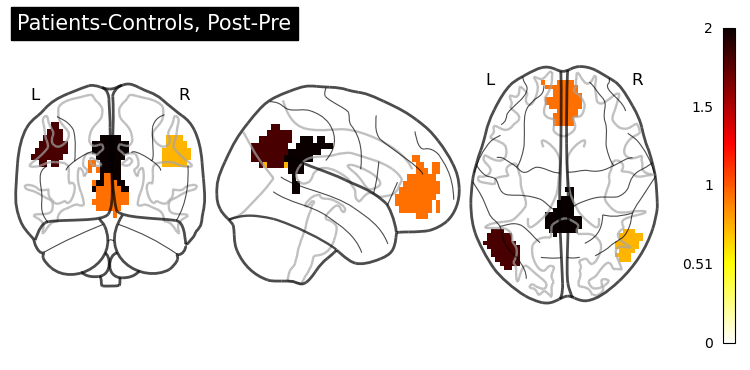

In [188]:
#Plotting! <0.001 uncorrected 
import numpy as np
import matplotlib.pyplot as plt
from nilearn import plotting

p001_unc = norm.isf(0.001)

contrast_id = "Patients-Controls, Post-Pre"    

contrast_val = contrasts[contrast_id] 
print(f"{contrast_id}; p<0.001 uncorrected")

# computing contrast: 
contrast = compute_contrast(secondlevel_labels, secondlevel_estimates, contrast_val)
z_score = contrast.z_score()

plotimg = masker.inverse_transform(z_score)

plotting.plot_glass_brain(
    plotimg,
    display_mode="ortho",
    title=contrast_id,
    plot_abs=False,
    colorbar=True
    )
plotting.show()

Patients-Controls, Post-Pre; Uncorrected


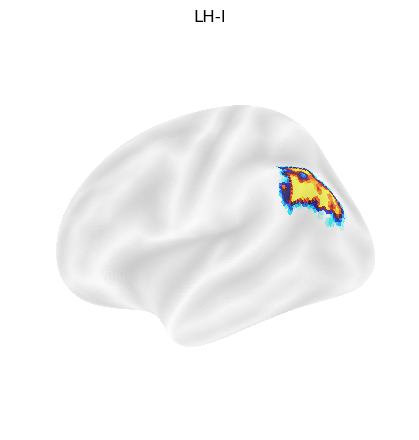

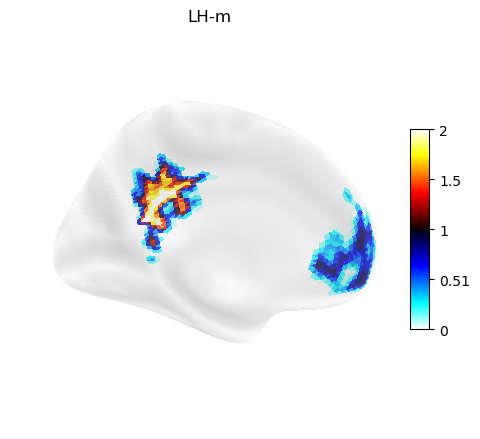

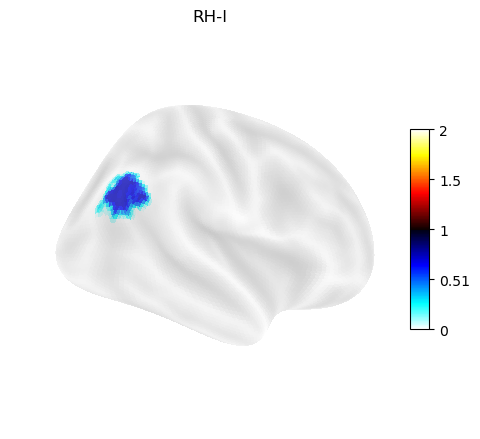

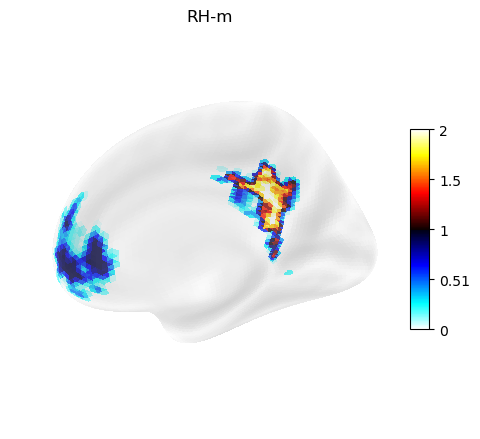

In [34]:
from nilearn import plotting, surface
from nilearn.surface import vol_to_surf

#Plotting surface! <0.001 uncorrected 
import numpy as np
import matplotlib.pyplot as plt
from nilearn import plotting

p001_unc = norm.isf(0.001)

contrast_id = "Patients-Controls, Post-Pre"    
contrast_val = contrasts[contrast_id] 
print(f"{contrast_id}; Uncorrected")   

z_map = plotimg

fsaverage = datasets.fetch_surf_fsaverage(mesh="fsaverage5")

texture_left = vol_to_surf(z_map, fsaverage.pial_left,interpolation='nearest')
texture_right = vol_to_surf(z_map, fsaverage.pial_right,interpolation='nearest')

plotting.plot_surf_stat_map(fsaverage.infl_left, texture_left, hemi='left', view='lateral',
    title="LH-l", colorbar=False, bg_map=fsaverage.sulc_left, bg_on_data=True)
plotting.show()

plotting.plot_surf_stat_map(
    fsaverage.infl_left, texture_left, hemi='left', view='medial',
    title="LH-m", colorbar=True, bg_map=fsaverage.sulc_left, bg_on_data=True)
plotting.show()

plotting.plot_surf_stat_map(
    fsaverage.infl_right, texture_right, hemi='right', view='lateral',
    title="RH-l", colorbar=True, bg_map=fsaverage.sulc_right, bg_on_data=True)
plotting.show()

plotting.plot_surf_stat_map(
    fsaverage.infl_right, texture_right, hemi='right', view='medial',
    title="RH-m", colorbar=True, bg_map=fsaverage.sulc_right, bg_on_data=True)
plotting.show()

In [189]:
#results: 
rois = ['MPFC','PCC','lTPJ','rTPJ']
ef = np.squeeze(contrast.effect_size())
p = contrast.p_value()

for no,roi in enumerate(rois):
    print(f"{roi}: beta = {ef[no]}, p = {p[no]}")
    

MPFC: beta = 0.43179183052125025, p = 0.1716046310347053
PCC: beta = 0.6388304210578151, p = 0.02025162537027527
lTPJ: beta = 0.9106174413874862, p = 0.03202417203710956
rTPJ: beta = 0.293957518903732, p = 0.22872698835308825


In [190]:
def fdr_threshold(p_values, alpha=0.05):
    # Sort p-values in ascending order
    sorted_indices = np.argsort(p_values)
    sorted_p_values = p_values[sorted_indices]

    # Calculate the critical value k
    num_tests = len(p_values)
    k = np.argmax(sorted_p_values > np.arange(1, num_tests + 1) * alpha / num_tests)

    # FDR threshold
    if k > 0:
        fdr_thresh = sorted_p_values[k - 1]
    else:
        fdr_thresh = 0.0

    return fdr_thresh

fdr_thresh = fdr_threshold(p)
print(f"FDR thresh: {fdr_thresh}")
if fdr_thresh == 0:
    print(f"no regions survive fdr correction")
else:
    for no,roi in enumerate(rois):
        if p[no] <= fdr_thresh:
            print(f"{roi} survives fdr <0.05, beta={ef[no]}, p={p[no]}")
# fdr_z = norm.isf(fdr_thresh)
# print(f'fdr z threshold: {fdr_z}')

FDR thresh: 0.0
no regions survive fdr correction


### Post-hoc tests

In [191]:
# post hoc tests 

# separating input matrix for post-hoc tests 

# Separate sessions and create sets for quick lookup
ses01_patients = {entry for entry in sub_order['self-other'] if entry.startswith('sub1') and entry.endswith('ses01')}
ses01_patient_indices = [i for i, entry in enumerate(sub_order['self-other']) if entry.startswith('sub1') and entry.endswith('ses01')]
ses01_patient_data = np.array([second_level_input[i] for i in ses01_patient_indices])

ses02_patients = {entry for entry in sub_order['self-other'] if entry.startswith('sub1') and entry.endswith('ses02')}
ses02_patient_indices = [i for i, entry in enumerate(sub_order['self-other']) if entry.startswith('sub1') and entry.endswith('ses02')]
ses02_patient_data = np.array([second_level_input[i] for i in ses02_patient_indices])

ses01_controls = {entry for entry in sub_order['self-other'] if entry.startswith('sub2') and entry.endswith('ses01')}
ses01_controls_indices = [i for i, entry in enumerate(sub_order['self-other']) if entry.startswith('sub2') and entry.endswith('ses01')]
ses01_controls_data = np.array([second_level_input[i] for i in ses01_controls_indices])

ses02_controls = {entry for entry in sub_order['self-other'] if entry.startswith('sub2') and entry.endswith('ses02')}
ses02_controls_indices = [i for i, entry in enumerate(sub_order['self-other']) if entry.startswith('sub2') and entry.endswith('ses02')]
ses02_controls_data = np.array([second_level_input[i] for i in ses02_controls_indices])

controls_prevpost = np.concatenate((ses01_controls_data,ses02_controls_data))
patients_prevpost = np.concatenate((ses01_patient_data,ses02_patient_data))


In [192]:
#pre/post second level design matrices (patients / controls sep) 

#patients 
# session variable
pre = []
session1 = np.ones(len(ses01_patients))
session2 = np.zeros(len(ses02_patients))
pre = np.concatenate((session1,session2))
pre = np.expand_dims(pre, axis = -1)

post = []
session1 = np.zeros(len(ses01_patients))
session2 = np.ones(len(ses02_patients))
post = np.concatenate((session1,session2))
post = np.expand_dims(post, axis = -1)


#subject-wise intercept
sub_matrix = []
sub_matrix2 = []
sub_matrix = np.identity(len(ses01_patients))
sub_matrix2 = np.delete(sub_matrix, 0, axis=0)  #- 102
sub_matrix2 = np.delete(sub_matrix2, 21, axis=0)  #- 138
sub_matrix2 = np.delete(sub_matrix2, 25, axis=0)  #- 145

sub_matrix = np.concatenate((sub_matrix,sub_matrix2))

# put all together 
patients_prevpost_sldm = np.hstack((pre,post,sub_matrix))

#controls 
# session variable
pre = []
session1 = np.ones(len(ses01_controls))
session2 = np.zeros(len(ses02_controls))
pre = np.concatenate((session1,session2))
pre = np.expand_dims(pre, axis = -1)

post = []
session1 = np.zeros(len(ses01_controls))
session2 = np.ones(len(ses02_controls))
post = np.concatenate((session1,session2))
post = np.expand_dims(post, axis = -1)

#subject-wise intercept
sub_matrix = []
sub_matrix2 = []
sub_matrix = np.identity(len(ses01_controls))
sub_matrix2 = np.delete(sub_matrix, 5, axis=0)  #- 209
sub_matrix2 = np.delete(sub_matrix2, 13, axis=0)  #- 221
sub_matrix2 = np.delete(sub_matrix2, 23, axis=0)  #- 237

sub_matrix = np.concatenate((sub_matrix,sub_matrix2))

# put all together 
controls_prevpost_sldm = np.hstack((pre,post,sub_matrix))

In [193]:
patients = subjects[0:30]
controls = subjects[30:58]

In [194]:
# fitting second level model 
patients_labels, patients_estimates = run_glm(patients_prevpost, patients_prevpost_sldm)

controls_labels, controls_estimates = run_glm(controls_prevpost, controls_prevpost_sldm)


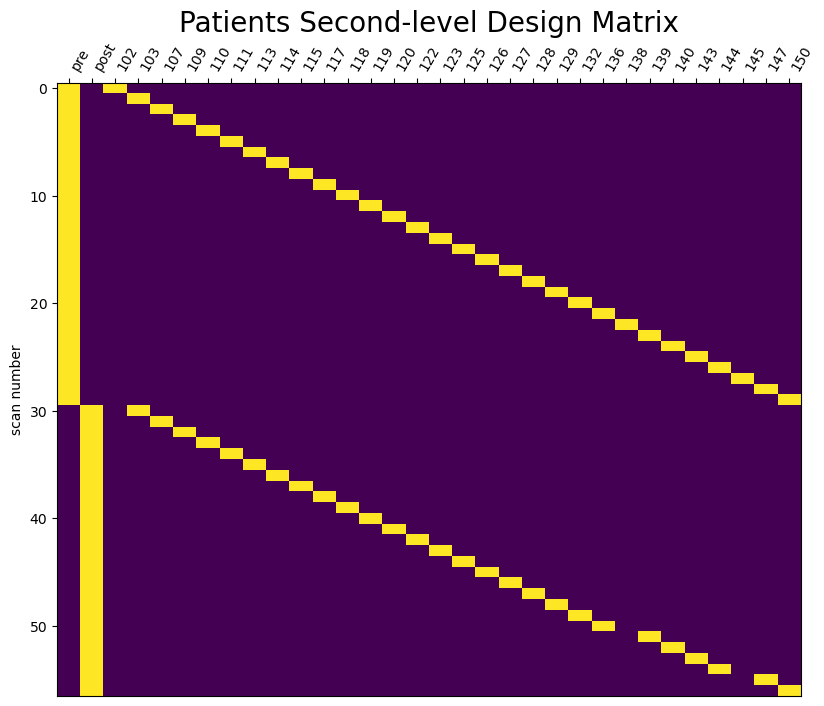

{'post-pre': array([-1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.])}

In [195]:
# plotting second level design matrix + adding column names for contrasts 
patients_prevpost_sldm = pd.DataFrame(patients_prevpost_sldm, columns=['pre'] +['post'] + patients)
patients_prevpost_sldm.to_excel("/Users/angelafang/Desktop/patients_prevpost_sldm.xlsx")

from nilearn.glm.second_level import SecondLevelModel 
plotting.plot_design_matrix(patients_prevpost_sldm, rescale=False)
plt.title("Patients Second-level Design Matrix", fontsize=20)
plotting.show()

contrast_matrix = np.eye(patients_prevpost_sldm.shape[1])
basic_contrasts = {
    column: contrast_matrix[i]
    for i, column in enumerate(patients_prevpost_sldm.columns)
    }

contrasts = {
    "post-pre": (basic_contrasts["post"]-basic_contrasts["pre"]),
    }      
contrasts

Patients Post-Pre p<0.001 uncorrected


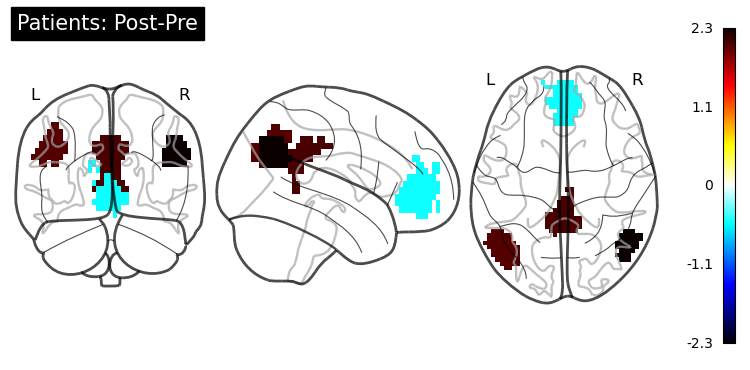

MPFC: beta = -0.24747830904969126, p = 0.709732788618809
PCC: beta = 0.5954106333481541, p = 0.01874416489660846
lTPJ: beta = 0.9354578779872298, p = 0.021073440170882102
rTPJ: beta = 0.7813650192327527, p = 0.010832531838841279
FDR thresh: 0.021073440170882102
PCC survives fdr <0.05, beta=0.5954106333481541, p=0.01874416489660846
lTPJ survives fdr <0.05, beta=0.9354578779872298, p=0.021073440170882102
rTPJ survives fdr <0.05, beta=0.7813650192327527, p=0.010832531838841279


In [196]:
#Plotting! <0.001 uncorrected 
import numpy as np
import matplotlib.pyplot as plt
from nilearn import plotting

p001_unc = norm.isf(0.001)

# Add a bolded super title
print('Patients Post-Pre p<0.001 uncorrected')

contrast_val = contrasts['post-pre'] 
contrast_id = 'Post-Pre'

contrast = compute_contrast(patients_labels, patients_estimates, contrast_val)
z_score = contrast.z_score()

plotimg = masker.inverse_transform(z_score)

plotting.plot_glass_brain(
    plotimg,
    display_mode="ortho",
    title='Patients: ' + contrast_id,
    plot_abs=False,
    colorbar=True
    )
plotting.show()

#results: 
rois = ['MPFC','PCC','lTPJ','rTPJ']
ef = np.squeeze(contrast.effect_size())
p = contrast.p_value()

for no,roi in enumerate(rois):
    print(f"{roi}: beta = {ef[no]}, p = {p[no]}")

fdr_thresh = fdr_threshold(p)
print(f"FDR thresh: {fdr_thresh}")
if fdr_thresh == 0:
    print(f"no regions survive fdr correction")
else:
    for no,roi in enumerate(rois):
        if p[no] <= fdr_thresh:
            print(f"{roi} survives fdr <0.05, beta={ef[no]}, p={p[no]}")

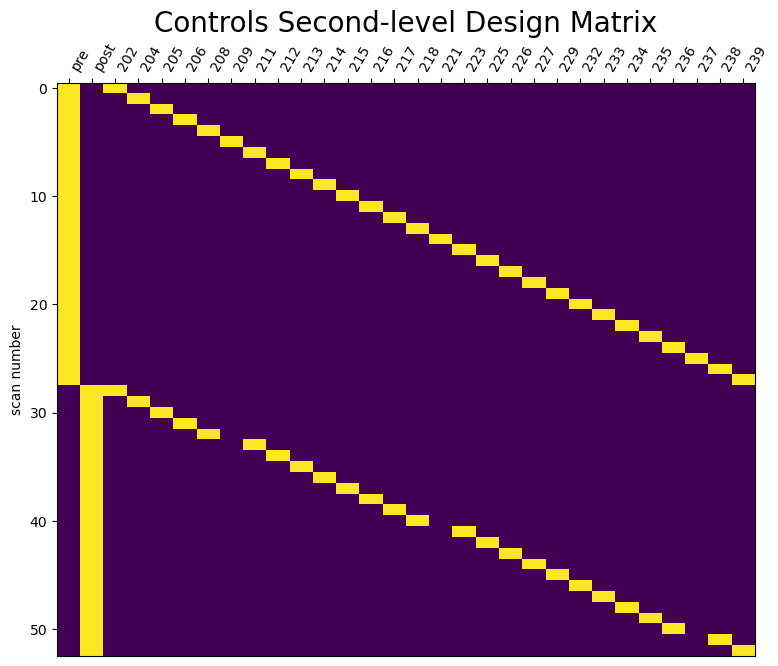

{'post-pre': array([-1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.])}

In [197]:
# plotting second level design matrix + adding column names for contrasts 
controls_prevpost_sldm = pd.DataFrame(controls_prevpost_sldm, columns=['pre'] +['post'] + controls)
controls_prevpost_sldm.to_excel("/Users/angelafang/Desktop/controls_prevpost_sldm.xlsx")

from nilearn.glm.second_level import SecondLevelModel 
plotting.plot_design_matrix(controls_prevpost_sldm, rescale=False)
plt.title("Controls Second-level Design Matrix", fontsize=20)
plotting.show()

contrast_matrix = np.eye(controls_prevpost_sldm.shape[1])
basic_contrasts = {
    column: contrast_matrix[i]
    for i, column in enumerate(controls_prevpost_sldm.columns)
    }

contrasts = {
    "post-pre": (basic_contrasts["post"]-basic_contrasts["pre"]),
    }      
contrasts

Controls Post-Pre p<0.001 uncorrected


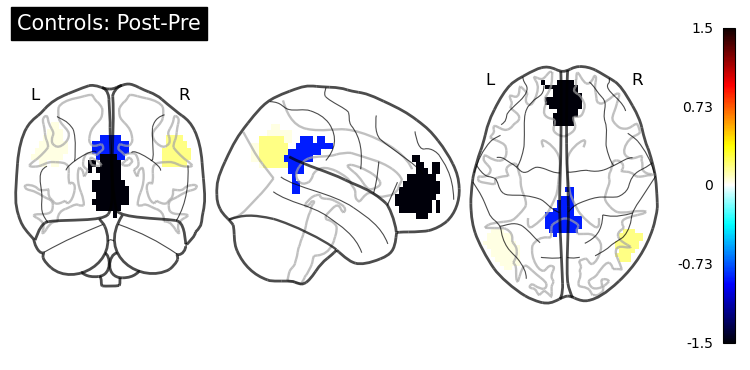

MPFC: beta = -0.6701865848338587, p = 0.9265483248708705
PCC: beta = -0.2570522629541232, p = 0.8050212855632084
lTPJ: beta = 0.02211864067271302, p = 0.48225675677321134
rTPJ: beta = 0.07974256661403212, p = 0.42989998471011903
FDR thresh: 0.0
no regions survive fdr correction


In [198]:
#Plotting! <0.001 uncorrected 
import numpy as np
import matplotlib.pyplot as plt
from nilearn import plotting

p001_unc = norm.isf(0.001)

# Add a bolded super title
print('Controls Post-Pre p<0.001 uncorrected')

contrast_val = contrasts['post-pre'] 
contrast_id = 'Post-Pre'

contrast = compute_contrast(controls_labels, controls_estimates, contrast_val)
z_score = contrast.z_score()

plotimg = masker.inverse_transform(z_score)

plotting.plot_glass_brain(
    plotimg,
    display_mode="ortho",
    title='Controls: ' + contrast_id,
    plot_abs=False,
    colorbar=True
    )
plotting.show()

#results: 
rois = ['MPFC','PCC','lTPJ','rTPJ']
ef = np.squeeze(contrast.effect_size())
p = contrast.p_value()

for no,roi in enumerate(rois):
    print(f"{roi}: beta = {ef[no]}, p = {p[no]}")

fdr_thresh = fdr_threshold(p)
print(f"FDR thresh: {fdr_thresh}")
if fdr_thresh == 0:
    print(f"no regions survive fdr correction")
else:
    for no,roi in enumerate(rois):
        if p[no] <= fdr_thresh:
            print(f"{roi} survives fdr <0.05, beta={ef[no]}, p={p[no]}")

In [199]:
#### POST-HOC WITHIN-SESSION PATIENTS-CONTROLS ####
pre_patientsvcontrols = np.concatenate((ses01_patient_data,ses01_controls_data))
post_patientsvcontrols = np.concatenate((ses02_patient_data,ses02_controls_data))


#pre/post second level design matrices (patients / controls sep) 

#pre  
# session variable
patients = []
session1 = np.ones(len(ses01_patients))
session2 = np.zeros(len(ses01_controls))
patients = np.concatenate((session1,session2))
patients = np.expand_dims(patients, axis = -1)

controls = []
session1 = np.zeros(len(ses01_patients))
session2 = np.ones(len(ses01_controls))
controls = np.concatenate((session1,session2))
controls = np.expand_dims(controls, axis = -1)

# put all together 
pre_sldm = np.hstack((patients,controls))

#pre  
# session variable
patients = []
session1 = np.ones(len(ses02_patients))
session2 = np.zeros(len(ses02_controls))
patients = np.concatenate((session1,session2))
patients = np.expand_dims(patients, axis = -1)

controls = []
session1 = np.zeros(len(ses02_patients))
session2 = np.ones(len(ses02_controls))
controls = np.concatenate((session1,session2))
controls = np.expand_dims(controls, axis = -1)

# put all together 
post_sldm = np.hstack((patients,controls))

# fitting second level glm! 
pre_labels, pre_estimates = run_glm(pre_patientsvcontrols, pre_sldm)

post_labels, post_estimates = run_glm(post_patientsvcontrols, post_sldm)


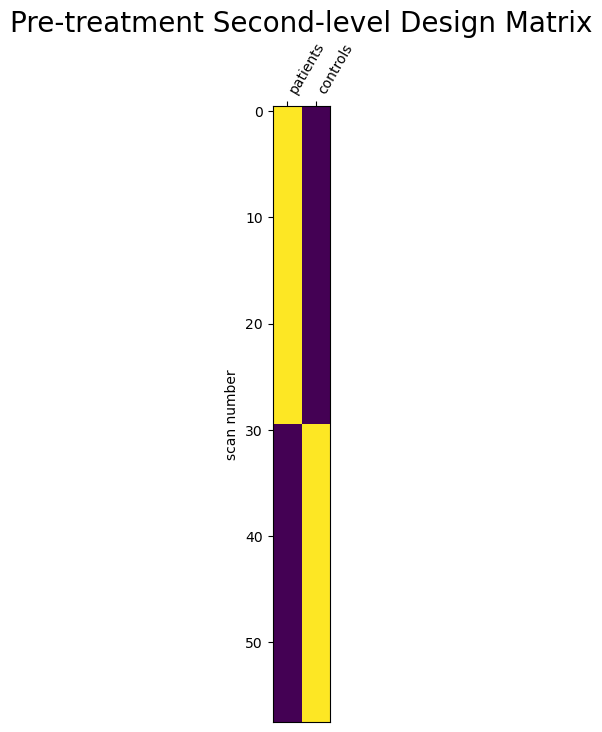

In [207]:
# plotting second level design matrix + adding column names for contrasts 
pre_sldm = pd.DataFrame(pre_sldm, columns=['patients'] +['controls'])
pre_sldm.to_excel("/Users/angelafang/Desktop/pre_sldm.xlsx")

from nilearn.glm.second_level import SecondLevelModel 
plotting.plot_design_matrix(pre_sldm, rescale=False)
plt.title("Pre-treatment Second-level Design Matrix", fontsize=20)
plotting.show()

Pre Patients-Controls p<0.001 uncorrected


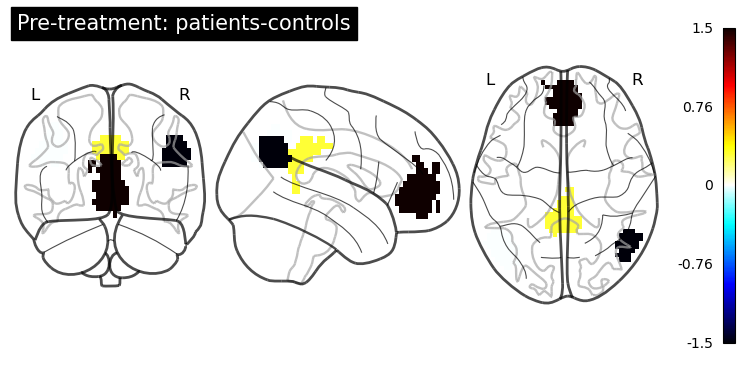

MPFC: beta = 0.7094204621790934, p = 0.06650952280931417
PCC: beta = 0.07053293768951371, p = 0.3827467056777283
lTPJ: beta = -0.00014202994717926742, p = 0.5001474486209823
rTPJ: beta = -0.5013389030227308, p = 0.9354778130707235
FDR thresh: 0.0
no regions survive fdr correction


In [201]:
# PRE TREATMENT PATIENTS-CONTROLS (PLOTTING)
contrast_matrix = np.eye(pre_sldm.shape[1])
basic_contrasts = {
    column: contrast_matrix[i]
    for i, column in enumerate(pre_sldm.columns)
        }

contrasts = {
    "patients-controls": (basic_contrasts["patients"]-basic_contrasts["controls"]),
    }      
contrasts

print('Pre Patients-Controls p<0.001 uncorrected')

contrast_val = contrasts['patients-controls'] 
contrast_id = 'patients-controls'  

contrast = compute_contrast(pre_labels, pre_estimates, contrast_val)
z_score = contrast.z_score()


plotimg = masker.inverse_transform(z_score)

plotting.plot_glass_brain(
    plotimg,
    display_mode="ortho",
    title='Pre-treatment: ' + contrast_id,
    plot_abs=False,
    colorbar=True
    )
plotting.show()

#results: 
rois = ['MPFC','PCC','lTPJ','rTPJ']
ef = np.squeeze(contrast.effect_size())
p = contrast.p_value()

for no,roi in enumerate(rois):
    print(f"{roi}: beta = {ef[no]}, p = {p[no]}")

fdr_thresh = fdr_threshold(p)
print(f"FDR thresh: {fdr_thresh}")
if fdr_thresh == 0:
    print(f"no regions survive fdr correction")
else:
    for no,roi in enumerate(rois):
        if p[no] <= fdr_thresh:
            print(f"{roi} survives fdr <0.05, beta={ef[no]}, p={p[no]}")


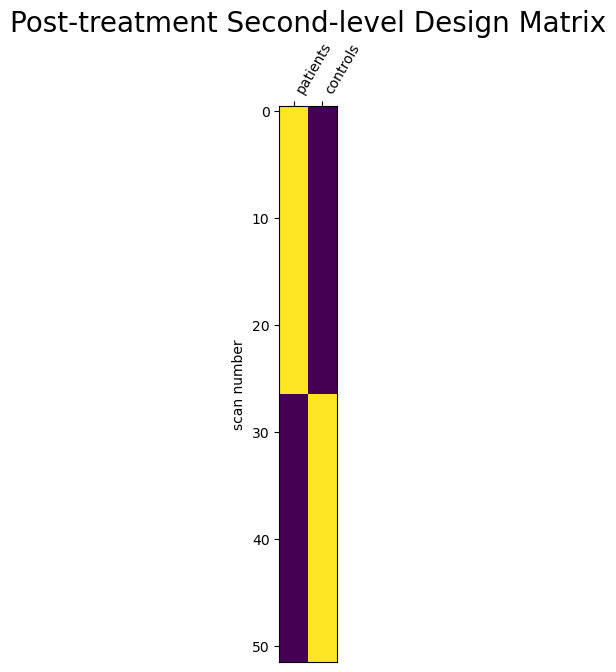

In [202]:
# plotting second level design matrix + adding column names for contrasts 
post_sldm = pd.DataFrame(post_sldm, columns=['patients'] +['controls'])
post_sldm.to_excel("/Users/angelafang/Desktop/post_sldm.xlsx")

from nilearn.glm.second_level import SecondLevelModel 
plotting.plot_design_matrix(post_sldm, rescale=False)
plt.title("Post-treatment Second-level Design Matrix", fontsize=20)
plotting.show()

Post Patients-Controls p<0.001 uncorrected


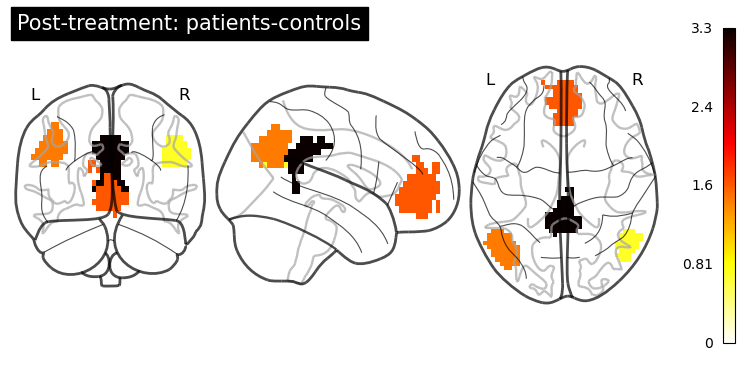

MPFC: beta = 0.9492692628145538, p = 0.051160656246699875
PCC: beta = 0.9550038956962915, p = 0.0005731649149680218
lTPJ: beta = 0.7431838935551462, p = 0.07328912549564782
rTPJ: beta = 0.29023681543528046, p = 0.2410165668118996
FDR thresh: 0.0005731649149680218
PCC survives fdr <0.05, beta=0.9550038956962915, p=0.0005731649149680218


In [203]:
# PRE TREATMENT PATIENTS-CONTROLS (PLOTTING)
contrast_matrix = np.eye(post_sldm.shape[1])
basic_contrasts = {
    column: contrast_matrix[i]
    for i, column in enumerate(post_sldm.columns)
    }

contrasts = {
    "patients-controls": (basic_contrasts["patients"]-basic_contrasts["controls"]),
    }      
contrasts

print('Post Patients-Controls p<0.001 uncorrected')

contrast_val = contrasts['patients-controls'] 
contrast_id = 'patients-controls'  

contrast = compute_contrast(post_labels, post_estimates, contrast_val)
z_score = contrast.z_score()


plotimg = masker.inverse_transform(z_score)

plotting.plot_glass_brain(
    plotimg,
    display_mode="ortho",
    title='Post-treatment: ' + contrast_id,
    plot_abs=False,
    colorbar=True
    )
plotting.show()

#results: 
rois = ['MPFC','PCC','lTPJ','rTPJ']
ef = np.squeeze(contrast.effect_size())
p = contrast.p_value()

for no,roi in enumerate(rois):
    print(f"{roi}: beta = {ef[no]}, p = {p[no]}")

fdr_thresh = fdr_threshold(p)
print(f"FDR thresh: {fdr_thresh}")
if fdr_thresh == 0:
    print(f"no regions survive fdr correction")
else:
    for no,roi in enumerate(rois):
        if p[no] <= fdr_thresh:
            print(f"{roi} survives fdr <0.05, beta={ef[no]}, p={p[no]}")


In [ ]:
# subtracting ses02 - ses01 

# Dictionary to store the paths for each subject and session
subject_sessions = {}

# Populate the dictionary
for file_path in file_lists['self-other']:
    base_name = os.path.basename(file_path)
    parts = base_name.split('_')
    subject = parts[0]
    session = parts[-1].split('.')[0]
    if subject not in subject_sessions:
        subject_sessions[subject] = {}
    subject_sessions[subject][session] = file_path

# List to store the subtraction results
subtraction_results = []
postmpre_inputs = []
# Loop through each subject and perform the subtraction
for subject, sessions in subject_sessions.items():
    if 'ses01' in sessions and 'ses02' in sessions:
        # Load the NIfTI files
        ses01_img = nib.load(sessions['ses01'])
        ses02_img = nib.load(sessions['ses02'])
        
        # Extract the data
        ses01_data = ses01_img.get_fdata()
        ses02_data = ses02_img.get_fdata()
        result_data = []
        # Perform the subtraction
        result_data = ses02_data - ses01_data
        result_data = nib.Nifti1Image(result_data, ses02_img.affine, ses02_img.header)

        # Append the result to the list
        subtraction_results.append((result_data))
        output_file = f'{subject}_subtraction_result.nii.gz'
        nib.save(result_data, output_file)
        postmpre_inputs.append([output_file])
        print(f'Appended result for {subject}')
    else:
        print(f'Subject {subject} does not have both ses01 and ses02 files')

In [157]:
subjects


['102',
 '103',
 '107',
 '109',
 '110',
 '111',
 '113',
 '114',
 '115',
 '117',
 '118',
 '119',
 '120',
 '122',
 '123',
 '125',
 '126',
 '127',
 '128',
 '129',
 '132',
 '136',
 '138',
 '139',
 '140',
 '143',
 '144',
 '145',
 '147',
 '150',
 '202',
 '204',
 '205',
 '206',
 '208',
 '209',
 '211',
 '212',
 '213',
 '214',
 '215',
 '216',
 '217',
 '218',
 '221',
 '223',
 '225',
 '226',
 '227',
 '229',
 '232',
 '233',
 '234',
 '235',
 '236',
 '237',
 '238',
 '239']

### Aim2B-v3: Predictive ability of DMN ROI activity for treatment response (% symptom change)

In [158]:
perc_symptom_change = [0.41, 0.50, 0.56, 0.49, 0.38, 0.57, 0.73, 0.39, 0.38, 0.72, 0.39, 0.38, 0.66, 0.34, 0.34, 0.60, 0.78, 0.37, 0.46, 0.26, 0.73, 0.43, 0.46, 0.43, 0.19, 0.30, 0.29]

In [165]:
perc_symptom_change = np.array(perc_symptom_change)
rois = ['MPFC','PCC','lTPJ','rTPJ']

In [3]:
ses01_patient_data.shape
ses01_patient_data_rv = np.delete(ses01_patient_data, 0, axis=0)  #- 102
ses01_patient_data_rv = np.delete(ses01_patient_data_rv, 21, axis=0)  #- 138
ses01_patient_data_rv = np.delete(ses01_patient_data_rv, 25, axis=0)  #- 145

patient_data = pd.DataFrame(ses01_patient_data_rv, columns=rois)
patient_data['perc_symptom_change'] = perc_symptom_change


NameError: name 'ses01_patient_data' is not defined

In [206]:
patient_data

NameError: name 'patient_data' is not defined

In [1]:
import statsmodels.api as sm

X = patient_data[rois]
X = sm.add_constant(X)

# Define the dependent variable
y = patient_data['perc_symptom_change']

# Fit the model
dmnroi_model = sm.OLS(y, X).fit()

# Print the summary of the regression
print(dmnroi_model.summary())

NameError: name 'patient_data' is not defined

### Post-Pre PCC, TPJ correlation treatment response

In [210]:
# post hoc tests 

# separating input matrix for post-hoc tests 

# Separate sessions and create sets for quick lookup
ses01_patients = {entry for entry in sub_order['self-other'] if entry.startswith('sub1') and entry.endswith('ses01')}
ses01_patient_indices = [i for i, entry in enumerate(sub_order['self-other']) if entry.startswith('sub1') and entry.endswith('ses01')]
ses01_patient_data = np.array([second_level_input[i] for i in ses01_patient_indices])

ses02_patients = {entry for entry in sub_order['self-other'] if entry.startswith('sub1') and entry.endswith('ses02')}
ses02_patient_indices = [i for i, entry in enumerate(sub_order['self-other']) if entry.startswith('sub1') and entry.endswith('ses02')]
ses02_patient_data = np.array([second_level_input[i] for i in ses02_patient_indices])

ses01_controls = {entry for entry in sub_order['self-other'] if entry.startswith('sub2') and entry.endswith('ses01')}
ses01_controls_indices = [i for i, entry in enumerate(sub_order['self-other']) if entry.startswith('sub2') and entry.endswith('ses01')]
ses01_controls_data = np.array([second_level_input[i] for i in ses01_controls_indices])

ses02_controls = {entry for entry in sub_order['self-other'] if entry.startswith('sub2') and entry.endswith('ses02')}
ses02_controls_indices = [i for i, entry in enumerate(sub_order['self-other']) if entry.startswith('sub2') and entry.endswith('ses02')]
ses02_controls_data = np.array([second_level_input[i] for i in ses02_controls_indices])

controls_prevpost = np.concatenate((ses01_controls_data,ses02_controls_data))
patients_prevpost = np.concatenate((ses01_patient_data,ses02_patient_data))


In [214]:
# subtracting ses02 - ses01 
ses01_patient_data = np.delete(ses01_patient_data, 0, axis=0)  #- 102
ses01_patient_data = np.delete(ses01_patient_data, 21, axis=0)  #- 138
ses01_patient_data = np.delete(ses01_patient_data, 25, axis=0)  #- 145


In [216]:
patients_postminuspre = ses02_patient_data-ses01_patient_data

In [222]:
ses02_patient_data


array([[ 0.96998563,  0.8876302 ,  1.79423973,  0.71451593],
       [ 0.67985284, -1.30264403, -0.9525662 , -3.42200072],
       [ 4.09039761,  0.42619718,  2.21837205, -1.0384212 ],
       [ 7.1522106 ,  3.52171808,  1.39587496,  1.4830386 ],
       [ 2.63967695, -0.11608744,  0.15499004,  0.58700223],
       [-2.07343076, -0.68892561, -1.13050102, -1.20627911],
       [ 2.56509921,  0.79553239,  2.86315904,  1.20040139],
       [ 6.7339248 ,  1.20106592,  0.35454114,  0.83991263],
       [ 1.22585634,  0.21940854,  0.30503888,  0.88277466],
       [ 3.94971633,  0.58947379, -0.21582321, -0.72444225],
       [ 5.81797957,  2.40386049,  1.45636819,  0.92572481],
       [ 1.54787921,  1.37100508,  0.96293829,  0.75668811],
       [ 0.43171052, -1.90757858, -0.90414915, -3.04737282],
       [-1.06488244, -0.32887829, -2.26650196, -1.13633161],
       [ 1.61597376,  1.86143314,  0.59702087, -0.35281012],
       [-1.3494294 ,  1.85547828,  6.79883944, -1.14688206],
       [ 3.15096796,  0.

In [218]:
ses01_patient_data

array([[ 1.54898891,  0.01253153, -0.06896835, -0.38188761],
       [ 2.48878628,  0.11939381, -0.50018709, -3.29728101],
       [ 5.68108577,  1.86854801,  3.49426659,  0.42477627],
       [ 4.72424604,  0.81167937,  0.6191064 , -0.39662171],
       [ 2.01981765, -0.08986821,  0.21110954, -0.48795398],
       [ 2.16728186, -0.13974593,  0.34240044, -1.49291156],
       [ 5.01586818,  0.2353237 ,  0.5060865 , -1.32419967],
       [ 4.11263387,  0.64420306,  0.46167769,  0.77877562],
       [ 3.46010193,  0.8374845 ,  0.02682135,  0.78047322],
       [ 1.27824197, -0.18809141,  0.60043702, -3.48382673],
       [ 6.02926666,  0.82950024, -1.28610507, -0.25380626],
       [ 2.56400162,  0.22650627,  0.39796604,  0.31038038],
       [ 4.25832656, -1.8091469 , -1.84914361, -1.62597355],
       [ 2.66236729, -0.15336978,  1.80912343, -2.06506508],
       [ 1.23418068,  1.38514606,  1.08780196,  0.39963843],
       [ 0.62382263,  0.4756235 ,  0.73156357, -1.48685303],
       [ 1.13843516, -0.

In [219]:
patients_postminuspre

array([[-0.57900329,  0.87509867,  1.86320808,  1.09640353],
       [-1.80893344, -1.42203784, -0.45237911, -0.12471971],
       [-1.59068816, -1.44235084, -1.27589455, -1.46319748],
       [ 2.42796457,  2.71003871,  0.77676856,  1.87966032],
       [ 0.6198593 , -0.02621923, -0.0561195 ,  1.07495622],
       [-4.24071262, -0.54917967, -1.47290145,  0.28663244],
       [-2.45076897,  0.56020868,  2.35707255,  2.52460106],
       [ 2.62129092,  0.55686286, -0.10713655,  0.06113702],
       [-2.2342456 , -0.61807595,  0.27821753,  0.10230144],
       [ 2.67147436,  0.77756519, -0.81626023,  2.75938448],
       [-0.21128709,  1.57436026,  2.74247326,  1.17953107],
       [-1.01612242,  1.14449881,  0.56497225,  0.44630773],
       [-3.82661604, -0.09843168,  0.94499447, -1.42139927],
       [-3.72724973, -0.17550851, -4.07562539,  0.92873347],
       [ 0.38179308,  0.47628709, -0.49078108, -0.75244855],
       [-1.97325203,  1.37985478,  6.06727587,  0.33997097],
       [ 2.01253281,  1.

In [220]:
perc_symptom_change = [0.41, 0.50, 0.56, 0.49, 0.38, 0.57, 0.73, 0.39, 0.38, 0.72, 0.39, 0.38, 0.66, 0.34, 0.34, 0.60, 0.78, 0.37, 0.46, 0.26, 0.73, 0.43, 0.46, 0.43, 0.19, 0.30, 0.29]

In [226]:
### Correlation of ROI change w treatment response 
from scipy.stats import pearsonr

# Initialize lists to store correlation coefficients and p-values
correlations = []
p_values = []

rois = ['MPFC','PCC','lTPJ','rTPJ']

# Calculate the correlation and p-value for each column
for i in range(patients_postminuspre.shape[1]):
    corr, p_value = pearsonr(patients_postminuspre[:, i], perc_symptom_change)
    correlations.append(corr)
    p_values.append(p_value)

# Print the correlation coefficients and p-values
for i, (corr, p_value) in enumerate(zip(correlations, p_values)):
    print(f"{rois[i]}: Pearson r = {corr}, p-value = {p_value}")



MPFC: Pearson r = -0.2363953107299618, p-value = 0.2351724633843835
PCC: Pearson r = -0.12865284735971053, p-value = 0.522475873129879
lTPJ: Pearson r = -0.015521979507720439, p-value = 0.9387488284896695
rTPJ: Pearson r = -0.012667207113663329, p-value = 0.9499986107230389


In [231]:
### linear regression of ROI change w treatment response 

col_label = ['PCC','lTPJ']
patient_data = pd.DataFrame(patients_postminuspre[:,1:3], columns=col_label)
patient_data['perc_symptom_change'] = perc_symptom_change
patient_data

import statsmodels.api as sm

X = patient_data[col_label]
X = sm.add_constant(X)

# Define the dependent variable
y = patient_data['perc_symptom_change']

# Fit the model
dmnroi_model = sm.OLS(y, X).fit()

# Print the summary of the regression
print(dmnroi_model.summary())

                             OLS Regression Results                            
Dep. Variable:     perc_symptom_change   R-squared:                       0.026
Model:                             OLS   Adj. R-squared:                 -0.055
Method:                  Least Squares   F-statistic:                    0.3180
Date:                 Fri, 19 Jul 2024   Prob (F-statistic):              0.731
Time:                         10:23:29   Log-Likelihood:                 12.622
No. Observations:                   27   AIC:                            -19.24
Df Residuals:                       24   BIC:                            -15.36
Df Model:                            2                                         
Covariance Type:             nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4727      0.034     13.74